In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:



ValueError: ignored

In [1]:
# Install the PyBullet module.
!pip install -U pybullet

Requirement already up-to-date: pybullet in /Users/portia/opt/anaconda3/lib/python3.6/site-packages (3.2.0)


In [2]:
useNullSpace = 1
ikSolver = 0
pandaEndEffectorIndex = 11 #8
pandaNumDofs = 7

ll = [-7]*pandaNumDofs
#upper limits for null space (todo: set them to proper range)
ul = [7]*pandaNumDofs
#joint ranges for null space (todo: set them to proper range)
jr = [7]*pandaNumDofs
#restposes for null space
jointPositions=[0.98, 0.458, 0.31, -2.24, -0.30, 2.66, 2.32, 0.02, 0.02]
rp = jointPositions

class PandaSim(object):
  def __init__(self, bullet_client, offset):
    self.bullet_client = bullet_client
    self.bullet_client.setPhysicsEngineParameter(solverResidualThreshold=0)
    self.offset = np.array(offset)
    flags = self.bullet_client.URDF_ENABLE_CACHED_GRAPHICS_SHAPES
    self.legos=[]
    table = self.bullet_client.loadURDF("table_square/table_square.urdf", [0+offset[0], -0.57+offset[1], -0.6+offset[2]], [-0.5, -0.5, -0.5, 0.5], flags=flags)
    plane = self.bullet_client.loadURDF("plane.urdf", [0+offset[0], -1+offset[1], -0.6+offset[2]], [-0.5, -0.5, -0.5, 0.5], flags=flags)
    self.bullet_client.changeVisualShape(table,-1,rgbaColor=[0,0,0,1])
    self.legos.append(self.bullet_client.loadURDF("lego/lego.urdf",np.array([0.1, 0.3, -0.5])+self.offset, flags=flags))
    self.bullet_client.changeVisualShape(self.legos[0],-1,rgbaColor=[1,0,0,1])
    self.legos.append(self.bullet_client.loadURDF("lego/lego.urdf",np.array([-0.1, 0.3, -0.5])+self.offset, flags=flags))
    self.legos.append(self.bullet_client.loadURDF("lego/lego.urdf",np.array([0.1, 0.3, -0.7])+self.offset, flags=flags))
    self.sphereId = self.bullet_client.loadURDF("cube_small.urdf",np.array( [0, 0.3, -0.6])+self.offset, flags=flags)
    self.bullet_client.loadURDF("cube_small.urdf",np.array( [0, 0.3, -0.5])+self.offset, flags=flags)
    self.bullet_client.loadURDF("cube_small.urdf",np.array( [0, 0.3, -0.7])+self.offset, flags=flags)
    orn=[-0.707107, 0.0, 0.0, 0.707107]#p.getQuaternionFromEuler([-math.pi/2,math.pi/2,0])
    eul = self.bullet_client.getEulerFromQuaternion([-0.5, -0.5, -0.5, 0.5])
    self.panda = self.bullet_client.loadURDF("franka_panda/panda.urdf", np.array([0,0,0])+self.offset, orn, useFixedBase=True, flags=flags)
    index = 0
    self.state = 0
    self.control_dt = 1./240.
    self.finger_target = 0
    self.gripper_height = 0.2
    #create a constraint to keep the fingers centered
    c = self.bullet_client.createConstraint(self.panda,
                       9,
                       self.panda,
                       10,
                       jointType=self.bullet_client.JOINT_GEAR,
                       jointAxis=[1, 0, 0],
                       parentFramePosition=[0, 0, 0],
                       childFramePosition=[0, 0, 0])
    self.bullet_client.changeConstraint(c, gearRatio=-1, erp=0.1, maxForce=50)
 
    for j in range(self.bullet_client.getNumJoints(self.panda)):
      self.bullet_client.changeDynamics(self.panda, j, linearDamping=0, angularDamping=0)
      info = self.bullet_client.getJointInfo(self.panda, j)
      #print("info=",info)
      jointName = info[1]
      jointType = info[2]
      if (jointType == self.bullet_client.JOINT_PRISMATIC):
        
        self.bullet_client.resetJointState(self.panda, j, jointPositions[index]) 
        index=index+1
      if (jointType == self.bullet_client.JOINT_REVOLUTE):
        self.bullet_client.resetJointState(self.panda, j, jointPositions[index]) 
        index=index+1
    self.t = 0.
  def reset(self):
    pass

  def update_state(self):
    keys = self.bullet_client.getKeyboardEvents()
    if len(keys)>0:
      for k,v in keys.items():
        if v&self.bullet_client.KEY_WAS_TRIGGERED:
          if (k==ord('1')):
            self.state = 1
          if (k==ord('2')):
            self.state = 2
          if (k==ord('3')):
            self.state = 3
          if (k==ord('4')):
            self.state = 4
          if (k==ord('5')):
                self.state = 5
          if (k==ord('6')):
                self.state = 6
        if v&self.bullet_client.KEY_WAS_RELEASED:
            self.state = 0
  def step(self):
    if self.state==6:
      self.finger_target = 0.01
    if self.state==5:
      self.finger_target = 0.04 
    self.bullet_client.submitProfileTiming("step")
    self.update_state()
    #print("self.state=",self.state)
    #print("self.finger_target=",self.finger_target)
    alpha = 0.9 #0.99
    if self.state==1 or self.state==2 or self.state==3 or self.state==4 or self.state==7:
      #gripper_height = 0.034
      self.gripper_height = alpha * self.gripper_height + (1.-alpha)*0.03 
      if self.state == 2 or self.state == 3 or self.state == 7:
        self.gripper_height = alpha * self.gripper_height + (1.-alpha)*0.2
      
      t = self.t
      self.t += self.control_dt
      pos = [self.offset[0]+0.2 * math.sin(1.5 * t), self.offset[1]+self.gripper_height, self.offset[2]+-0.6 + 0.1 * math.cos(1.5 * t)]
      if self.state == 3 or self.state== 4:
        pos, o = self.bullet_client.getBasePositionAndOrientation(self.legos[0])
        pos = [pos[0], self.gripper_height, pos[2]]
        self.prev_pos = pos
      if self.state == 7:
        pos = self.prev_pos
        diffX = pos[0] - self.offset[0]
        diffZ = pos[2] - (self.offset[2]-0.6)
        self.prev_pos = [self.prev_pos[0] - diffX*0.1, self.prev_pos[1], self.prev_pos[2]-diffZ*0.1]

      	
      orn = self.bullet_client.getQuaternionFromEuler([math.pi/2.,0.,0.])
      self.bullet_client.submitProfileTiming("IK")
      jointPoses = self.bullet_client.calculateInverseKinematics(self.panda,pandaEndEffectorIndex, pos, orn, ll, ul,
        jr, rp, maxNumIterations=20)
      self.bullet_client.submitProfileTiming()
      # target for joints
      for i in range(pandaNumDofs):
        self.bullet_client.setJointMotorControl2(self.panda, i, self.bullet_client.POSITION_CONTROL, jointPoses[i],force=5 * 240.)
      #target for fingers
    for i in [9,10]:
      self.bullet_client.setJointMotorControl2(self.panda, i, self.bullet_client.POSITION_CONTROL,self.finger_target ,force= 10)
    self.bullet_client.submitProfileTiming()


class PandaSimAuto(PandaSim):
  def __init__(self, bullet_client, offset):
    PandaSim.__init__(self, bullet_client, offset)
    self.state_t = 0
    self.cur_state = 0
    self.states=[0,3,5,4,6,3,7]
    self.state_durations=[1,1,1,2,1,1,10]
  
  def update_state(self):
    self.state_t += self.control_dt
    if self.state_t > self.state_durations[self.cur_state]:
      self.cur_state += 1
      if self.cur_state>=len(self.states):
        self.cur_state = 0
      self.state_t = 0
      self.state=self.states[self.cur_state]
      #print("self.state=",self.state)
      

In [3]:
import pybullet as p
import pybullet_data as pd
import math
from PIL import Image
import time
import numpy as np

createVideo=True
fps=120.
timeStep = 1./fps

p.connect(p.DIRECT)

p.configureDebugVisualizer(p.COV_ENABLE_Y_AXIS_UP,1)
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)
p.setPhysicsEngineParameter(maxNumCmdPer1ms=1000)
p.resetDebugVisualizerCamera(cameraDistance=1.5, cameraYaw=38, cameraPitch=-22, cameraTargetPosition=[0.35,-0.13,0])
p.setAdditionalSearchPath(pd.getDataPath())

p.setTimeStep(timeStep)
p.setGravity(0,-9.8,0)
panda = PandaSimAuto(p,[0,0,0])
panda.reset()
panda.control_dt = timeStep

logId = panda.bullet_client.startStateLogging(panda.bullet_client.STATE_LOGGING_PROFILE_TIMINGS, "log.json")
panda.bullet_client.submitProfileTiming("start")

0


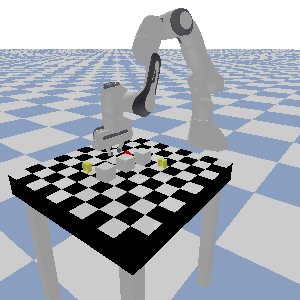

1


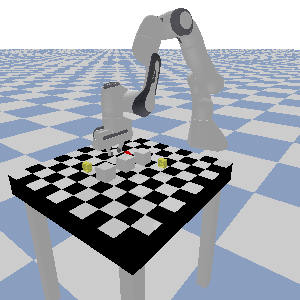

2


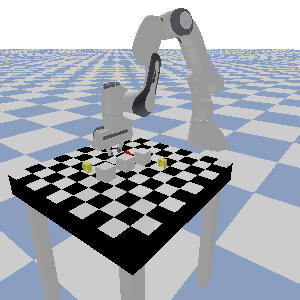

3


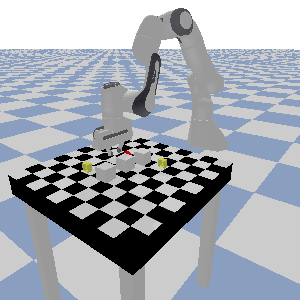

4


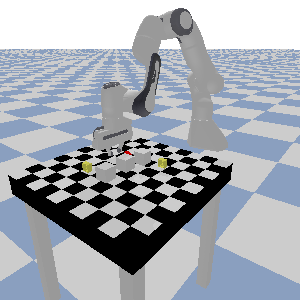

5


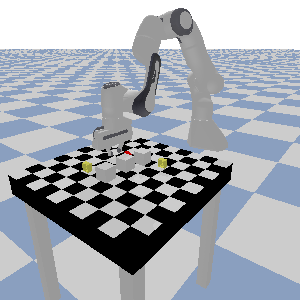

6


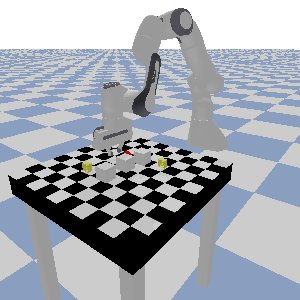

7


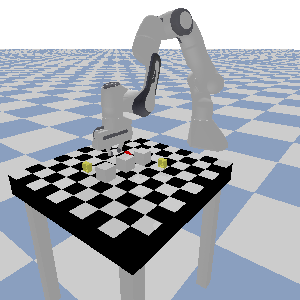

8


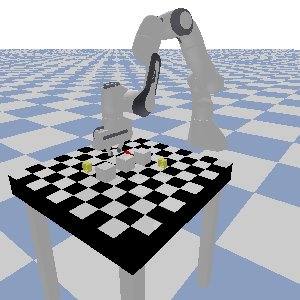

9


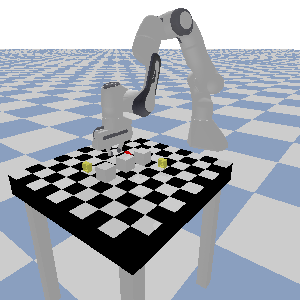

10


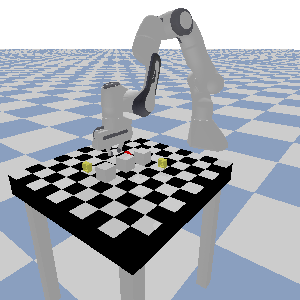

11


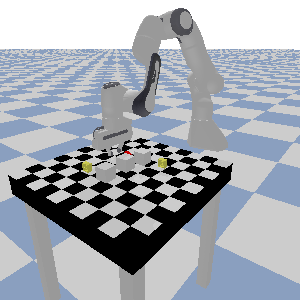

12


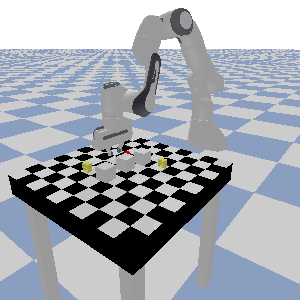

13


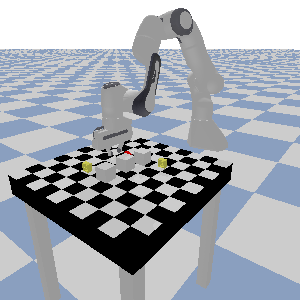

14


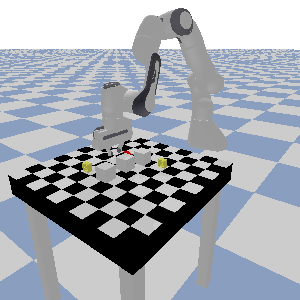

15


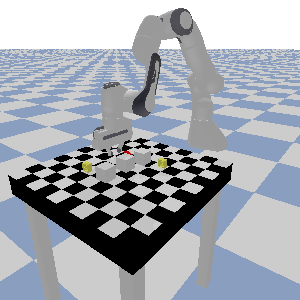

16


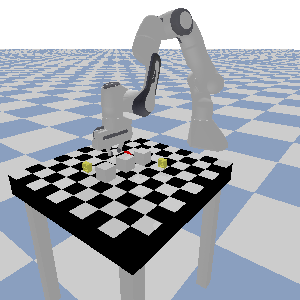

17


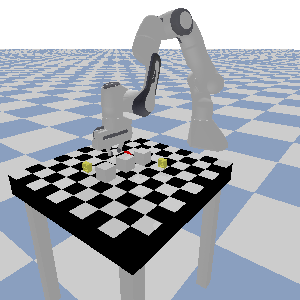

18


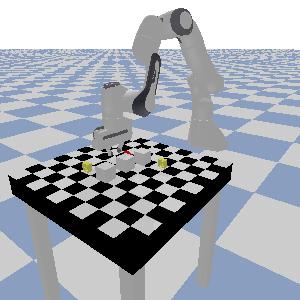

19


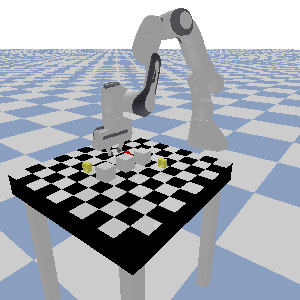

20


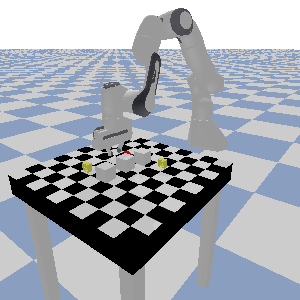

21


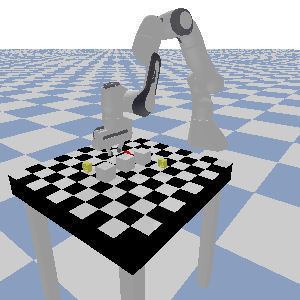

22


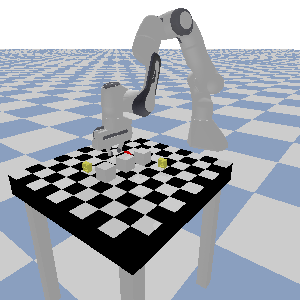

23


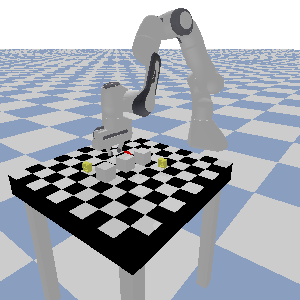

24


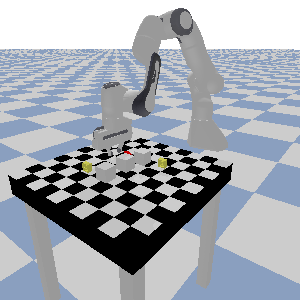

25


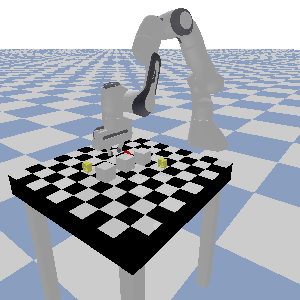

26


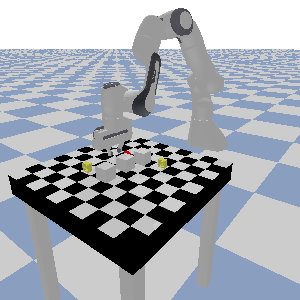

27


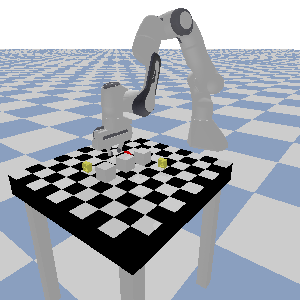

28


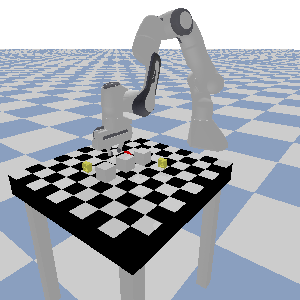

29


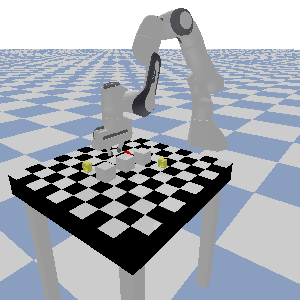

30


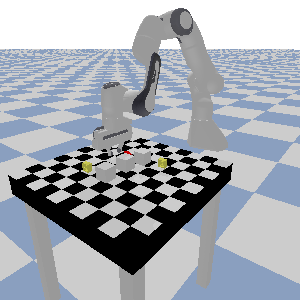

31


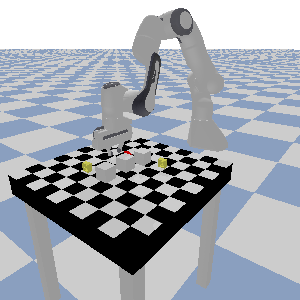

32


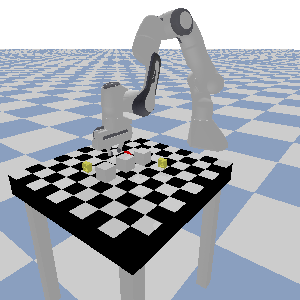

33


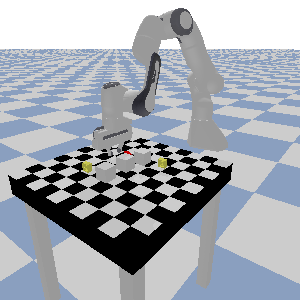

34


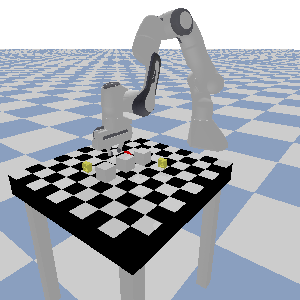

35


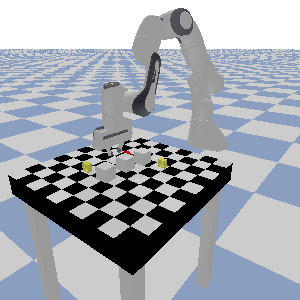

36


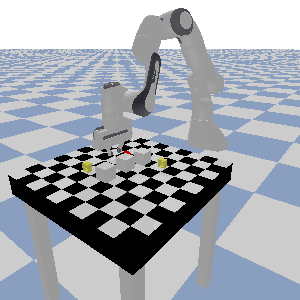

37


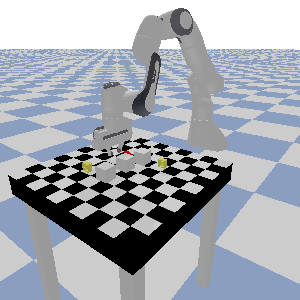

38


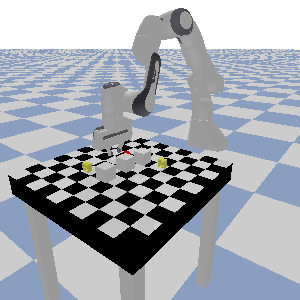

39


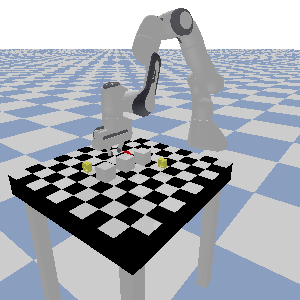

40


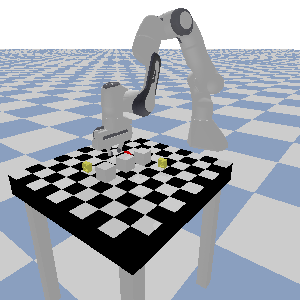

41


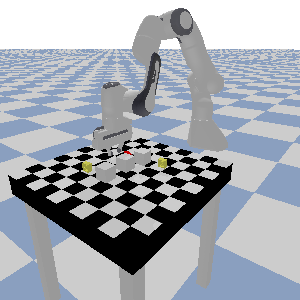

42


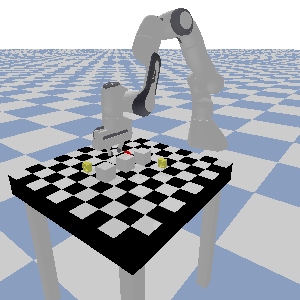

43


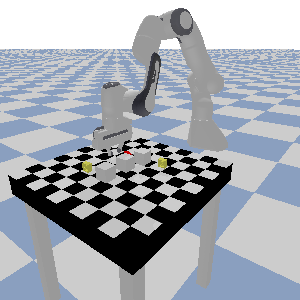

44


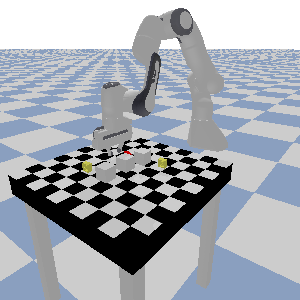

45


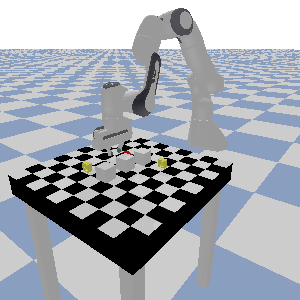

46


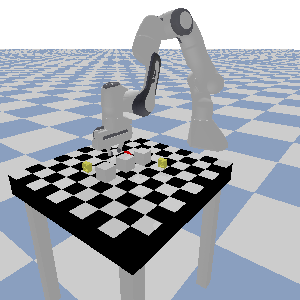

47


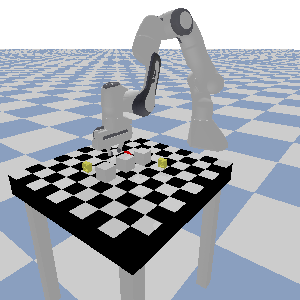

48


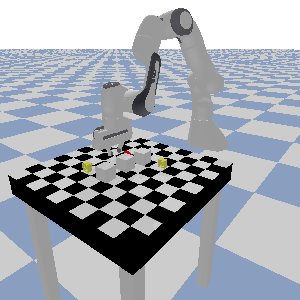

49


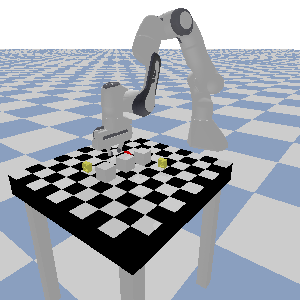

In [65]:
import cv2
import os

video_name = 'video.avi'
width = 300
height = 300
layers = 50

video = cv2.VideoWriter(video_name, 0, fps, (width,height))

for i in range (layers):
  print(i)
  panda.bullet_client.submitProfileTiming("full_step")
  panda.step()
  p.stepSimulation()
  if createVideo:
    img_arr = p.getCameraImage(
        width,
        height,
        viewMatrix=p.computeViewMatrixFromYawPitchRoll(
            cameraTargetPosition=[0.35,-0.13,0],
            distance=1.7,
            yaw=38,
            pitch=-22,
            roll=0,
            upAxisIndex=1,
        ),
        projectionMatrix=p.computeProjectionMatrixFOV(
            fov=60,
            aspect=width/height,
            nearVal=0.01,
            farVal=100,
        ),
        shadow=True,
        lightDirection=[1, 1, 1],
    )

    width, height, rgba, depth, mask = img_arr
    image = Image.fromarray(rgba, 'RGBA').convert('RGB')
    display(image)
    open_cv_image = np.array(image) 
    open_cv_image = open_cv_image[:, :, ::-1].copy() 
    video.write(open_cv_image)
    panda.bullet_client.submitProfileTiming()

cv2.destroyAllWindows()
video.release()


In [5]:
import os
file_path = 'video.avi'
output = 'video'
def convert_avi_to_mp4(avi_file_path, output_name):
    os.popen("ffmpeg -i '{input}' -r 240 -s 800x400 -f mp4 '{output}.mp4'".format(input = avi_file_path, output = output_name))
    return True
convert_avi_to_mp4(file_path,output)

True

In [67]:
# First let's define a class for the JointInfo.
from dataclasses import dataclass

@dataclass
class Joint:
  index: int
  name: str
  type: int
  gIndex: int
  uIndex: int
  flags: int
  damping: float
  friction: float
  lowerLimit: float
  upperLimit: float
  maxForce: float
  maxVelocity: float
  linkName: str
  axis: tuple
  parentFramePosition: tuple
  parentFrameOrientation: tuple
  parentIndex: int

  def __post_init__(self):
    self.name = str(self.name, 'utf-8')
    self.linkName = str(self.linkName, 'utf-8')

# Let's analyze the R2D2 droid!
#print(f"panda unique ID: {panda.panda}")
for i in range(p.getNumJoints(panda.panda)):
  joint = Joint(*p.getJointInfo(panda.panda, i))
  #print(joint)

To start the simulation, first we must set the gravity.
We'll use [Earth's gravity](http://www.geophys.ac.cn/infowin/Gravity.asp) for convenience, so we'll set it up to `-9.807` m/s<sup>2</sup>.

In [6]:
"""
# Set the gravity to Earth's gravity.
p.setGravity(0, 0, -9.807)

# Run the simulation for a fixed amount of steps.
for i in range(20):
    position, orientation = p.getBasePositionAndOrientation(r2d2)
    x, y, z = position
    roll, pitch, yaw = p.getEulerFromQuaternion(orientation)
    print(f"{i:3}: x={x:0.10f}, y={y:0.10f}, z={z:0.10f}), roll={roll:0.10f}, pitch={pitch:0.10f}, yaw={yaw:0.10f}")
    p.stepSimulation()
"""

'\n# Set the gravity to Earth\'s gravity.\np.setGravity(0, 0, -9.807)\n\n# Run the simulation for a fixed amount of steps.\nfor i in range(20):\n    position, orientation = p.getBasePositionAndOrientation(r2d2)\n    x, y, z = position\n    roll, pitch, yaw = p.getEulerFromQuaternion(orientation)\n    print(f"{i:3}: x={x:0.10f}, y={y:0.10f}, z={z:0.10f}), roll={roll:0.10f}, pitch={pitch:0.10f}, yaw={yaw:0.10f}")\n    p.stepSimulation()\n'

### Rendering

The [`getCameraImage`](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit?usp=sharing#heading=h.u1jisfnt6984)
API will return a RGB image, a depth buffer and a segmentation mask buffer with body unique ids of visible objects for each pixel

rgba shape=(200, 320, 4), dtype=uint8


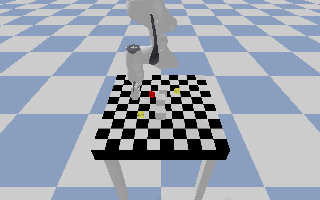

depth shape=(200, 320), dtype=float32, as values from 0.0 (near) to 1.0 (far)


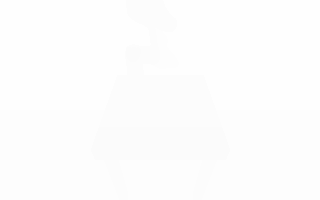

mask shape=(200, 320), dtype=int32, as unique values from 0 to N-1 entities, and -1 as None


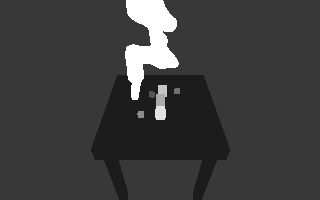

In [68]:
import numpy as np
from PIL import Image
from IPython.display import display

width = 320
height = 200
img_arr = p.getCameraImage(
    width,
    height,
    viewMatrix=p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[0, -2.5, 2.5],
        distance=5,
        yaw=0,
        pitch=-40,
        roll=0,
        upAxisIndex=1,
    ),
    projectionMatrix=p.computeProjectionMatrixFOV(
        fov=60,
        aspect=width/height,
        nearVal=0.01,
        farVal=100,
    ),
    shadow=True,
    lightDirection=[1, 1, 1],
)

width, height, rgba, depth, mask = img_arr
print(f"rgba shape={rgba.shape}, dtype={rgba.dtype}")
display(Image.fromarray(rgba, 'RGBA'))
print(f"depth shape={depth.shape}, dtype={depth.dtype}, as values from 0.0 (near) to 1.0 (far)")
display(Image.fromarray((depth*255).astype('uint8')))
print(f"mask shape={mask.shape}, dtype={mask.dtype}, as unique values from 0 to N-1 entities, and -1 as None")
display(Image.fromarray(np.interp(mask, (-1, mask.max()), (0, 255)).astype('uint8')))